In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, root_mean_squared_error, r2_score)

## 1. Read file and Display columns

In [2]:
csv_path = Path('data.csv')
df = pd.read_csv(csv_path)
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [3]:
print(df.shape)
print(df.dropna(axis=0, subset=['crew']).shape)

(158, 9)
(158, 9)


In [4]:
n_ships = len(df.Ship_name)
print(f'{n_ships=}')
lines = list(set(df.Cruise_line))
n_lines = len(lines)
print(f'{n_lines=}')

n_ships=158
n_lines=20


Text(0.5, 1.0, 'Number of ships vs cruise line')

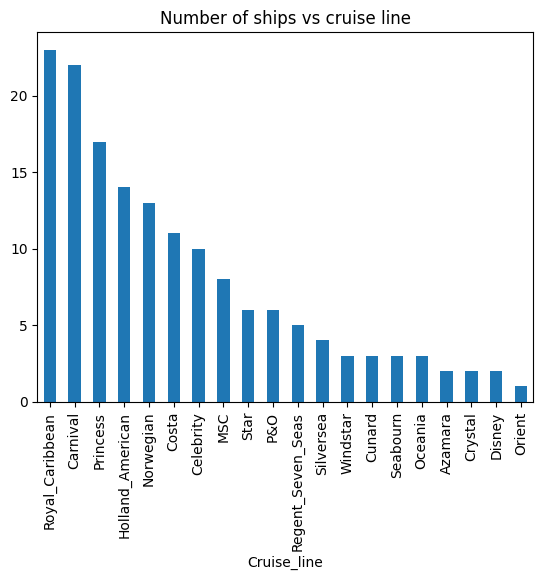

In [5]:
df.Cruise_line.value_counts().plot(kind='bar')
plt.title('Number of ships vs cruise line')

['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
3 2


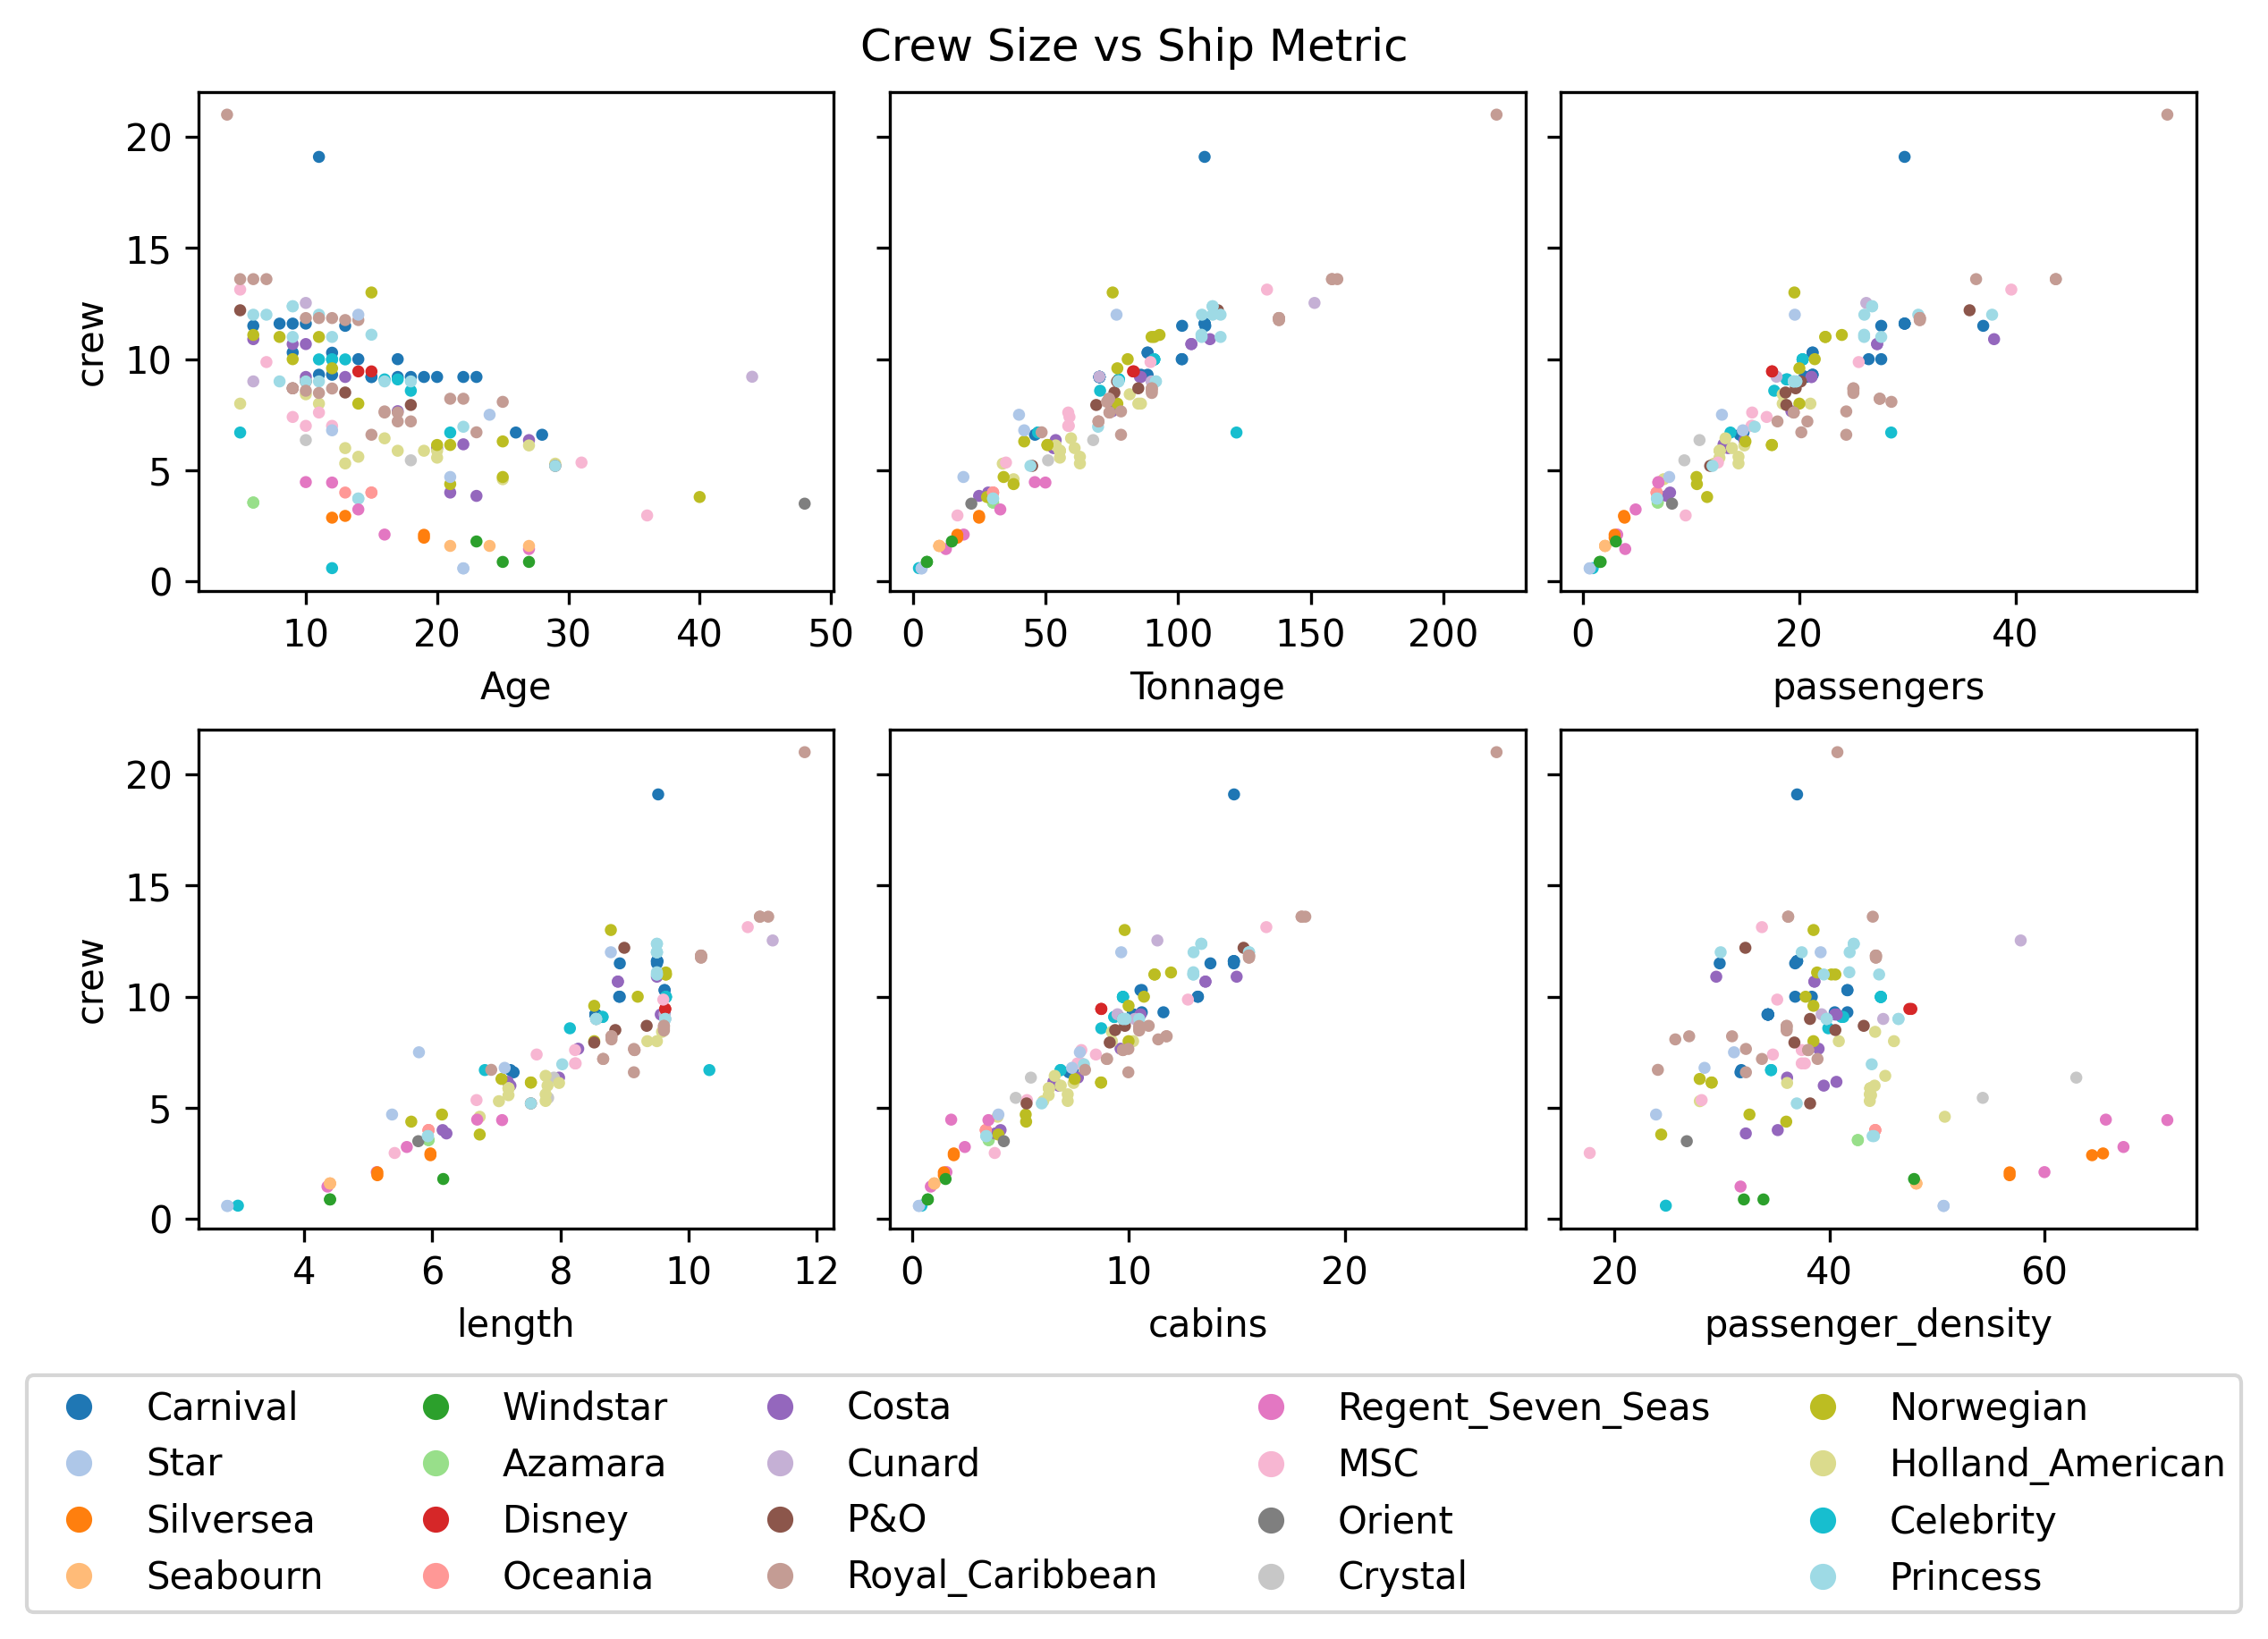

In [6]:
cols = [col for col in df.columns if col not in ['Ship_name', 'Cruise_line', 'crew']]
print(cols)
n_cols = len(cols)
plot_cols = 3
plot_rows = int(math.ceil(n_cols / plot_cols))
print(plot_cols, plot_rows)
fig, axes = plt.subplots(
    nrows=plot_rows, ncols=plot_cols, sharey=True, constrained_layout=True,
    dpi=300, figsize=(8, 5)
)
fig.suptitle('Crew Size vs Ship Metric')
ax = axes.ravel()
line_to_color = {
    line : color for line, color in
    zip(set(df.Cruise_line), mpl.colormaps['tab20'].colors)
}
for i, col in enumerate(cols):
    scatter = ax[i].scatter(
        df[col], df.crew,
        c=df.Cruise_line.map(line_to_color),
        s=5,
    )
    ax[i].set_xlabel(col)
    if i % plot_cols == 0:
        ax[i].set_ylabel('crew')
legendhandle = [
    plt.plot([], marker="o", ls="", color=color)[0]
    for color in list(line_to_color.values())
]
fig.legend(
    legendhandle, list(line_to_color.keys()), bbox_to_anchor=(0.5, 0), loc="upper center", ncol=5)

In [7]:
for col in cols:
    print(f'{col}:')
    mean = df[col].mean()
    std = df[col].std()
    std_frac = std / mean
    print(f'   {mean=}')
    print(f'   {std=}')

Age:
   mean=np.float64(15.689873417721518)
   std=np.float64(7.615691058751412)
Tonnage:
   mean=np.float64(71.28467088607596)
   std=np.float64(37.22954002590786)
passengers:
   mean=np.float64(18.457405063291137)
   std=np.float64(9.677094775143413)
length:
   mean=np.float64(8.130632911392404)
   std=np.float64(1.793473548054825)
cabins:
   mean=np.float64(8.83)
   std=np.float64(4.4714172221480615)
passenger_density:
   mean=np.float64(39.90094936708861)
   std=np.float64(8.639217113915416)


## 2. State observtions from exploratory analysis

By plotting the 6 quantitative metrics (and coloring the points by the categorical metric `Cruise_line`) against the `crew` metric, we can identify which metrics have the highest correlation with crew size. `Tonnage`, `passengers`, `length`, and `cabins` seem to have the largest correlation, as appear to show a trend, while the other metrics (`Age` and `passenger_desnity`) appear to be spread out near randomly. There appears to be some correlation with the color (`Cruise_line`) in some places, so this can't be ruled out as a predicting factor.

## 3. Use one-hot encoding for categorical features

In [8]:
X = pd.get_dummies(df, columns=['Cruise_line'], drop_first=True)
X.head()


,Ship_name,Age,Tonnage,passengers,length,cabins,passenger_density,crew,Cruise_line_Carnival,Cruise_line_Celebrity,...,Cruise_line_Oceania,Cruise_line_Orient,Cruise_line_P&O,Cruise_line_Princess,Cruise_line_Regent_Seven_Seas,Cruise_line_Royal_Caribbean,Cruise_line_Seabourn,Cruise_line_Silversea,Cruise_line_Star,Cruise_line_Windstar
0,Journey,6,30.277,6.94,5.94,3.55,42.64,3.55,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Quest,6,30.277,6.94,5.94,3.55,42.64,3.55,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Celebration,26,47.262,14.86,7.22,7.43,31.80,6.70,True,False,...,False,False,False,False,False,False,False,False,False,False
3,Conquest,11,110.000,29.74,9.53,14.88,36.99,19.10,True,False,...,False,False,False,False,False,False,False,False,False,False
4,Destiny,17,101.353,26.42,8.92,13.21,38.36,10.00,True,False,...,False,False,False,False,False,False,False,False,False,False


## 4. Select columns for predicting crew size

In [9]:
# Crew size is our target parameter, so we'll drop it from training
X = X.drop(['crew', 'Ship_name', 'Age', 'passenger_density'], axis=1)

`crew` must be removed from our training data since it is our target parameter. We are also dropping `Ship name`, as that is unrelated, as well as `Age` and `passenger_desnity` to avoid over-complicating our model with parameters that don't help predict crew size.

## 5. Create training and testing sets

In [10]:
y = df['crew']
# Split the data into 60% training and 40% testing per recommendation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

## 6. Build a machine learning models to predict crew size

To decide test different models, I followed [this flowchart](https://scikit-learn.org/stable/machine_learning_map.html) on the scikit-learn website.

### Linear Regression

In [11]:
# Start with linear regression
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 0.5091525701667117
Mean Squared Error: 0.7677658626998597
R-squared: 0.9533445957543581


### Lasso

In [12]:
model = Lasso()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 0.8976051998016218
Mean Squared Error: 1.2709906467212584
R-squared: 0.8721416576375174


### Ridge

In [13]:
model = Ridge()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 0.5190521077124195
Mean Squared Error: 0.7637858345932386
R-squared: 0.9538270566963915


## 7. Calculate model performance metrics

I chose Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) to assess the performance of these models.

## 8. Describe the hyper-parameters

The Ridge model in Scikit-learn introduces a hyper-parameter `alpha` which introduces a penalty to update the initial weights of a model during training.

### Tune hyper-parameters

In [14]:
# Define the parameter grid
# param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid = {'alpha': np.logspace(-3, 3, 50)}

# Initialize the Ridge regression model
ridge = Ridge()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best alpha for Ridge regression:", grid_search.best_params_)
print("Best MSE score:", -grid_search.best_score_)

# Train final model with best parameters
best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)


Best alpha for Ridge regression: {'alpha': np.float64(3.5564803062231287)}
Best MSE score: 1.081601005779035


In [15]:
# Evaluate final model on test set
mae = mean_absolute_error(y_test, y_pred)
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 0.5443252274296644
Mean Squared Error: 0.7747415992170626
R-squared: 0.952492944672397


## 9. Describe regularization

Regularization is a method for avoiding overfitting in machine learning by penalizing larget coefficients/weights in the model. `alpha` is the regularization parameter in this Ridge model.

## 10. Plot the regularization parameter vs a chosen performance metric

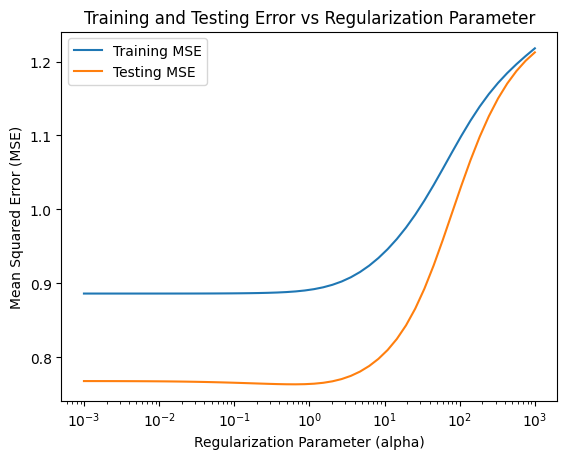

In [16]:
# Define a range of alpha values from 0.001 to 1000
alphas = np.logspace(-3, 3, 50)
mse_train = []
mse_test = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    # Predict on training and test sets
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    # Calculate MSE for training and test sets
    mse_train.append(root_mean_squared_error(y_train, y_train_pred))
    mse_test.append(root_mean_squared_error(y_test, y_test_pred))

fig, ax = plt.subplots()
ax.plot(alphas, mse_train, label='Training MSE')
ax.plot(alphas, mse_test, label='Testing MSE')
ax.set_xscale('log')
ax.set_xlabel('Regularization Parameter (alpha)')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Testing Error vs Regularization Parameter')
ax.legend()


We see a lower error for the testing data than the training data for low regularization parameter values, which means that we likely have high variance in the data as opposed to bias. This could also be due to outliers in the data. If we had bias in our training, we would see lower error in the training data than the test data, telling us that our model was likely overfit and had a hard time adjusting to more generalized data.